In [1]:
from andromeda.util.common import read_pickle, write_pickle
import pandas as pd
import numpy as np

## Build KMean Cluster

In [2]:
output_name = '15_new_rolling'
num_clusters = 15
random_state = 1234
runs = 20

In [3]:
res003 = pd.read_pickle('/Users/aphri/pycharm/data/wv_ticker_mapped_cleaned_new.pkl')
res003.head()

,s,vo,wv,ticker
date,,,,
2018-07-03 18:16:26,centene corporation,reports quarter earnings of per share,"[0.069821596, 0.2268446, -0.1357558, -0.047921...",[CNC]
2014-01-30 13:09:06,nfl,encourage fans shopping to purchase from nfl t...,"[0.07208228, -0.0021257144, 0.2515124, -0.1012...",[NFLX]
2020-11-10 06:07:36,las agencias de turismo se deben reinventar lu...,lets worldwide travel colombia por design,"[0.19914782, 0.078872666, 0.17587417, -0.07582...","[ALK, LVS]"
2019-10-24 23:13:31,oracle blockchain,provide single source of truth for hyperledger...,"[-0.074229, -0.017419994, -0.079432994, -0.071...",[ORCL]
2013-12-02 00:58:41,amazon best selling author callan rush worksho...,fill events,"[-0.17017, 0.029013999, 0.1578735, -0.16875601...",[AMZN]


In [4]:
res003_sorted = res003.sort_index()
res003_sorted['id'] = range(len(res003_sorted))
res003_1y = res003_sorted[res003_sorted.index < '2011-01-01'] 
res003_2y = res003_sorted[res003_sorted.index < '2012-01-01'] 

In [5]:
from sklearn.cluster import KMeans
from andromeda.nlp.processor import WordVector


def train_kmean_cluster(wv_df, **kwargs):
    wv_df = wv_df.squeeze()
    wv_matrix=np.array([list(value) for value in wv_df.values])
    
    km = KMeans(**kwargs)
    km.fit(wv_matrix)
    
    return km


def get_wv_model():
    wv = WordVector()
    wv_model = wv.processor
    
    return wv_model


def cluster_summary(km, wv_model):
    cluster_words = {}
    for i in range(len(km.cluster_centers_)):
        words = [t[0] for t in wv_model.similar_by_vector(km.cluster_centers_[i])]
        cluster_words[i] = words
    
    return cluster_words


def similarity(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))


def is_match(wv1, wv2, threshold=0.8):
    
    words = set(wv1 + wv2)
    w1 = set(wv1)
    w2 = set(wv2)
    
    score = 0
    for w in words:
        if w in w1 and w in w2:
            score = score + 1
        else:
            score = score - 0.0
    
    score = score / len(words)
    
    #print(wv1)
    #print(wv2)
    #print(f'score: {score}')
    
    if score > threshold:
        return True
    
    return False


def find_match(wv, cluster, threshold=0.8):
    
    for k, v in cluster.items():
        
        if is_match(wv, v, threshold):
            return k
    
    return None


def match_clusters(cluster1, cluster2, threshold=0.8):
    
    c1 = dict()
    c1.update(cluster1)
    c2 = dict()
    c2.update(cluster2)
    
    res = {}
    for k, v in c1.items():
        
        match = find_match(c1[k], c2, threshold)
        
        if match is not None:
            res[k] = match
            c2.pop(match)
        else:
            res[k] = -1
        
    return res


def find_cluster(wv, km):
    
    max_similarity = 0
    wv_cluster = -1
    for i, cluster in enumerate(km.cluster_centers_):
        current_similarity = similarity(wv, cluster)
        if current_similarity > max_similarity:
            max_similarity = current_similarity
            wv_cluster = i
    
    return wv_cluster

C:\Users\aphri\miniconda3\envs\pycharm\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [43]:
from pandas.tseries.offsets import DateOffset

def map_wv(data, prev_cut_off, cut_off, km):
    
    def map_cluster(wv):
        return find_cluster(wv, km)
    
    data_subset = data[prev_cut_off + DateOffset(days=1):cut_off].copy()
    data_subset['cluster'] = data_subset['wv'].apply(map_cluster)
    
    return data_subset[['id', 'cluster']]
    
# expanding
def construct_factors(data,
                      num_clusters=15,
                      base_period=365,
                      increment=180,
                      km_seed=1234):
    
    data = data.copy()
    data['id'] = range(len(data))
    
    end_date = data.index.max().date()
    cut_off = data.index.min().date() + DateOffset(days=base_period)
    
    wv_model = get_wv_model()
    
    km_dict = {}
    map_dict = {}
    cluster_dict = {}
    
    prev_cut_off = None
    terminate = False
    while not terminate:
        if cut_off == prev_cut_off:
            break
            
        print(f"processing {cut_off}")
        
        # do work
        data_subset = data[:cut_off + DateOffset(days=1)].copy()
        km = train_kmean_cluster(data_subset['wv'],
                                 n_clusters=num_clusters,
                                 random_state=km_seed)
        cluster_words = cluster_summary(km, wv_model)
        km_dict[cut_off] = (km, cluster_words)
        
        data_subset['cluster'] = km.labels_.tolist()
        
        current_cluster = data_subset[['id', 'cluster']].copy()
        
        if prev_cut_off is not None:
            prev_km, prev_cluster_words = km_dict[prev_cut_off]
            match_dict = match_clusters(prev_cluster_words, cluster_words)
            map_dict[(prev_cut_off, cut_off)] = match_dict
            
            prev_cluster = cluster_dict[prev_cut_off].copy()
            prev_cluster = prev_cluster.replace({'cluster': match_dict})
            
            current_cluster = current_cluster[~current_cluster['id'].isin(prev_cluster['id'])]
            current_cluster = pd.concat([prev_cluster, current_cluster], axis=0)
        
        prev_cut_off = cut_off
        cut_off = min(cut_off + DateOffset(days=increment), end_date)
        
        mapped_cluster = map_wv(data, prev_cut_off, cut_off, km)
        current_cluster = pd.concat([current_cluster, mapped_cluster], axis=0)
        
        cluster_dict[prev_cut_off] = current_cluster
        
    idx_name = data.index.name
    res = data.reset_index().merge(current_cluster, how='left', on='id').set_index(idx_name)
    
    return res, km_dict, map_dict, cluster_dict

In [10]:
res, km_dict, map_dict, cluster_dict = construct_factors(res003_sorted, increment=30)

processing 2010-09-25 00:00:00
processing 2010-10-25 00:00:00
processing 2010-11-24 00:00:00
processing 2010-12-24 00:00:00
processing 2011-01-23 00:00:00
processing 2011-02-22 00:00:00
processing 2011-03-24 00:00:00
processing 2011-04-23 00:00:00
processing 2011-05-23 00:00:00
processing 2011-06-22 00:00:00
processing 2011-07-22 00:00:00
processing 2011-08-21 00:00:00
processing 2011-09-20 00:00:00
processing 2011-10-20 00:00:00
processing 2011-11-19 00:00:00
processing 2011-12-19 00:00:00
processing 2012-01-18 00:00:00
processing 2012-02-17 00:00:00
processing 2012-03-18 00:00:00
processing 2012-04-17 00:00:00
processing 2012-05-17 00:00:00
processing 2012-06-16 00:00:00
processing 2012-07-16 00:00:00
processing 2012-08-15 00:00:00
processing 2012-09-14 00:00:00
processing 2012-10-14 00:00:00
processing 2012-11-13 00:00:00
processing 2012-12-13 00:00:00
processing 2013-01-12 00:00:00
processing 2013-02-11 00:00:00
processing 2013-03-13 00:00:00
processing 2013-04-12 00:00:00
processi

In [17]:
last_km = km_dict[res003_sorted.index.max().date()]

In [23]:
for cluster, words in last_km[1].items():
    print(cluster)
    print(words)

0
['company', 'acquisition', 'acquires', 'inc.', 'corporation', 'acquire', 'investment', 'acquired', 'management', 'corp.']
1
['one', 'will', 'it', 'make', 'that', 'well', 'even', 'we', 'up', 'but']
2
['de', 'en', 'la', 'el', 'que', 'y', 'es', 'del', 'por', 'para']
3
['conference', 'present', 'meeting', 'will', 'today', 'next', 'we', 'the', 'held', 'that']
4
['award', 'one', 'year', 'first', 'the', 'that', 'both', 'which', 'has', 'as']
5
['provide', 'provides', 'providing', 'which', 'technology', 'that', 'allows', 'will', 'system', 'well']
6
['dividend', 'earnings', 'dividends', 'quarterly', 'income', 'shares', 'profit', 'revenue', 'quarter', 'equity']
7
['that', 'will', 'must', 'however', 'which', 'should', 'whether', 'any', 'following', 'if']
8
['announces', 'announced', 'announce', 'launches', 'its', 'plans', 'company', 'announcement', 'announcing', 'launch']
9
['quarter', 'report', 'fourth', 'third', 'last', 'year', 'result', 'first', 'expected', 'second']
10
['where', 'city', 'the

In [96]:
res.groupby('cluster')['cluster'].count()

cluster
-1     39821
 0      1528
 1      1768
 2       706
 3      2136
 4      2000
 5      1464
 6      1019
 7       877
 8      5334
 9      2356
 10       23
 11     2192
 12     1757
 13     2057
 14     1228
Name: cluster, dtype: int64

In [24]:
cluster_name = {
    0: 'acquisition',
    12: 'management'
}

In [25]:
res['factor'] = res['cluster'].map(cluster_name)

In [26]:
returns = pd.read_pickle('sp500_daily_returns.pkl')
sp500_gics = pd.read_pickle('sp500_gics.pkl')

In [45]:
from andromeda.finance.analytics.portfolio import factors_from_cluster
res004 = factors_from_cluster(res)

ANALYZING: acquisition
                Sharpe  Volatility
roll-None    -0.448822    0.211725
roll-13      -0.220181    0.199083
roll-100     -0.198632    0.188170
roll-15      -0.168288    0.194887
roll-8       -0.163037    0.207277
roll-2       -0.123695    0.219814
roll-10      -0.039979    0.205480
roll-5       -0.032084    0.215704
equal weight  0.000000    0.194879
sector neutral:
                Sharpe  Volatility
roll-None    -0.348826    0.212875
roll-100     -0.112761    0.189576
roll-13      -0.108013    0.200100
roll-15      -0.097325    0.196736
roll-8       -0.017151    0.208377
equal weight  0.000000    0.192620
roll-5        0.009890    0.222076
roll-2        0.032001    0.224701
roll-10       0.084837    0.207434
ANALYZING: management
                Sharpe  Volatility
roll-5       -0.200427    0.247530
roll-15      -0.050272    0.213195
roll-8       -0.031002    0.229055
equal weight  0.000000    0.200316
roll-100      0.008536    0.198267
roll-13       0.054437    0.2

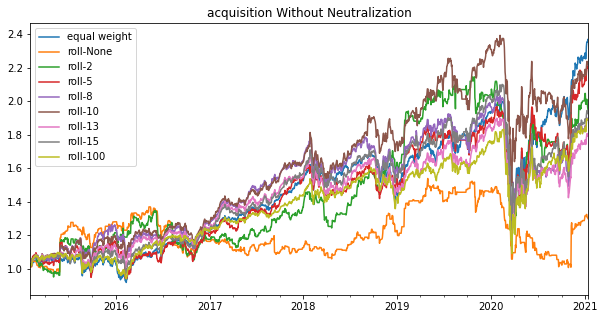

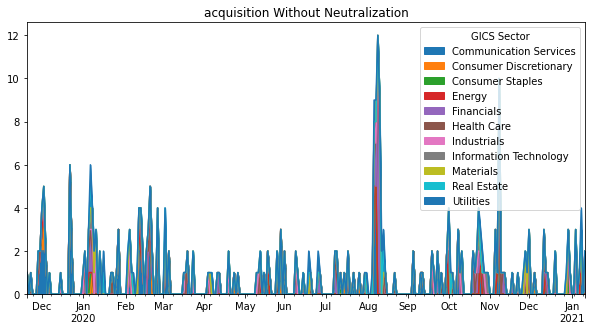

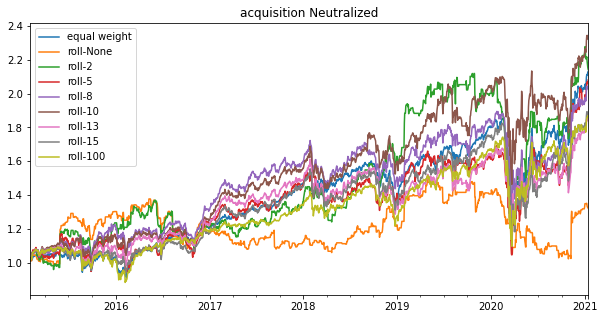

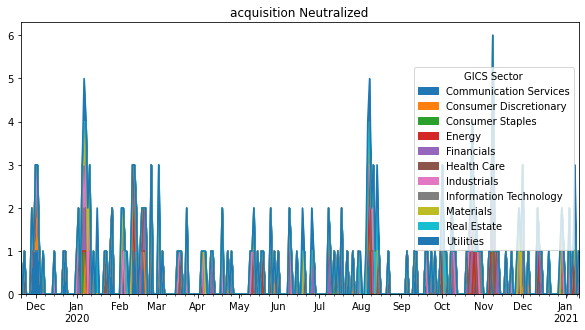

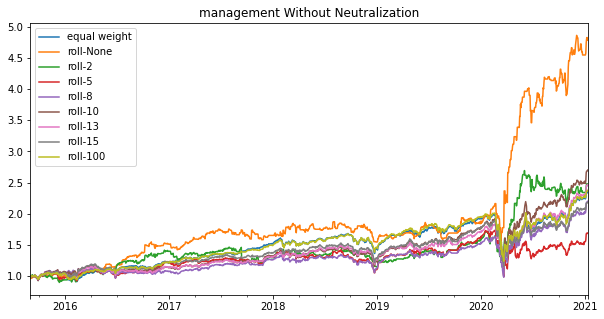

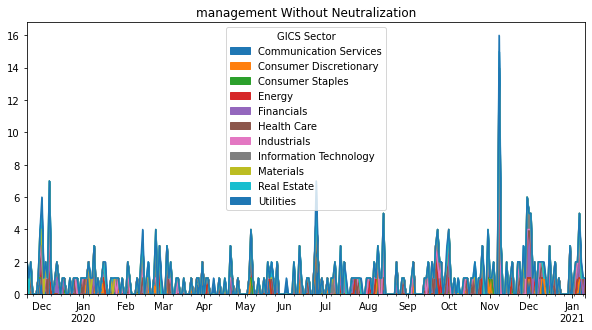

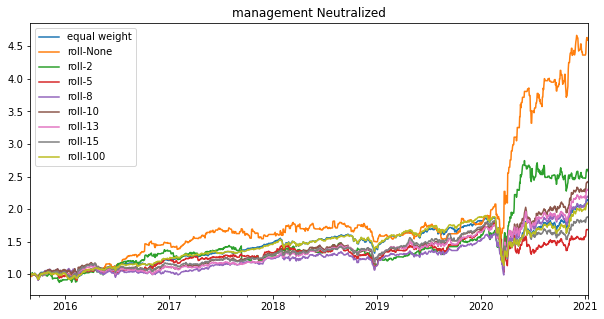

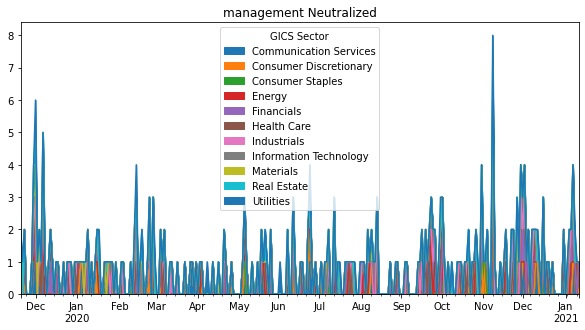

In [47]:
import andromeda.finance.analytics.performance as perf

for k, v in cluster_name.items():
    perf.analyze_factor(v, res004, returns, sp500_gics)

In [ ]:
#km_dict, map_dict, cluster_dict

In [64]:
from pandas import Timestamp
times = [Timestamp('2010-09-25 00:00:00'), Timestamp('2010-10-25 00:00:00'), Timestamp('2010-11-24 00:00:00')]

In [87]:
for i in range(len(times)-1):
    t1 = times[i]
    t2 = times[i+1]
    print(f"{times[i]} to {times[i+1]}")
    
    id_map = pd.DataFrame(data={'from': map_dict[(t1, t2)].keys(),
                                'to': map_dict[(t1, t2)].values()})
    id_map = id_map.set_index('from').transpose()
    print(id_map)
    
    cluster_words1 = km_dict[t1][1]
    w_map1 = pd.DataFrame(data={'from_id': cluster_words1.keys(),
                                'from_words': [v[:3] for v in cluster_words1.values()]}).set_index('from_id')
    print(w_map1)
    
    cluster_words2 = km_dict[t2][1]
    w_map2 = pd.DataFrame(data={'to_id': cluster_words2.keys(),
                                'to_words': [v[:3] for v in cluster_words2.values()]}).set_index('to_id')
    print(w_map2)


2010-09-25 00:00:00 to 2010-10-25 00:00:00
from  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
to     5   4  -1  10  12  -1   2  14   3  11  -1  -1  -1  -1  -1
                               from_words
from_id                                  
0         [acquisition, company, acquire]
1                 [that, whether, should]
2                        [new, one, will]
3        [announces, announced, announce]
4         [dividend, earnings, dividends]
5          [conference, present, meeting]
6             [president, director, vice]
7               [quarter, report, fourth]
8            [service, services, provide]
9                [million, billion, year]
10        [provide, technology, provides]
11                      [one, first, the]
12                 [that, provide, which]
13                      [one, make, even]
14                     [which, will, one]
                               to_words
to_id                                  
0      [provide, technology, prov

In [ ]:
# 1. some cluster without prominent topic will be clustered differently in subsequent clustering
# 2. strong clusters tend to remain